## Problem statement
<b><i>Given an image, create an algorithm to  identify the sections where there is no product present.  </i></b>

## Solutions

This is a void detecction problem which is a part of planogram where we continuously monitor a shelf with a static camera and generate soft alerts based on item replishment and hard alerts on void detection.

There are various approches using which we can solve the problem
- Image processing
    - Void detections with a void template
    - With a reference image
- ML/AI
    - With a supervised parametric AI model


### semi supervised approach

#### with a void template

<b> Algorithm </b>
- Input -  Create a void template (an subsection of the image that denotes empty shelf)
- Read image 
- Read void template image
- scan entire image and look for areas which likely denotes an empty shelf(match void template locally in the image)
- record the bbox coordinates where there is  95% similarity between the local regions and shelf image
- Remove false detections using non max compression
- scan boxes from left to right and ssign them unique id
- Output - list of boxes depicting the top-left  and bottom-right coordinates of empty sections

#### PROS
- Simple to implement 
- Easy to interpret
- semi supervised

#### CONS
- Not very robust,To handle robustness will have to create sufficiently large no of templates which will make it slower
- Not robust to nonlinear transformations
- chances of detecting false positives are high
- Due to exact match, This will not be work properly for all environments , Can't handle scale invariance (will have to create multiscale templates to handle multiscale match),rotation,different lightning conditons, change in angle etc 
- matching thresholds might differ for different objects

#### with a reference image

<b> Algorithm </b>
- Input - Continous stream of images
- At every n time interval take a snapshot of the shelf
- Compare snapshot of time t with snapshot of time t-1(refernce image)
- Calculate similarity between the snapshots
- record the bbox coordinates where there is a difference greater than a specific threshold 
- Remove false detections using non max compression
- scan boxes from left to right and ssign them unique id
- Output - list of boxes depicting the top-left  and bottom-right coordinates of empty sections

#### PROS
- Fast 
- Accurate and fast in changes detection 

#### CONS
- Requires a continuos stream of images
- Not very robust
- Even a slight changes in the subsequent image may lead to false detections
- is not size invariant
- similarity thresold might vary for diffrent conditions

### Supervised approach

#### with image and ground truth boxes

<b> Algorithm </b>
- create training dataset with covering all possible cases of void occurance in the store
    - Record a video stream of the shelves with products and no product
    - Record positive and negative cases
    - Label a void in one frame, then use an object tracker to label the void for the rest of the frames. This would multiply the number of labels by about 30, assuming a 30 FPS camera and a void-on-screen-time of one second.
    - This would create sufficiently large training set in a very short time
    - record image and bboxes as ground truth ([image_id,[[x1,y1,x2,y2,class_id]]])
- Train a deep learning object detection model(One stage like SSD,YOLO or 2 stage like Faster RCNN, depending on speed accuracy tradeoff )
- Evaluate the model's metric 
- Deploy the model with best capacity
- Pass static image from the camera to the model
- record detections as void coordinates
- Output - list of boxes depicting the top-left  and bottom-right coordinates of empty sections

#### PROS
- Robust
- can handle scale invariances
- can handle occlusions
- can handle rotation
- Robust to nonlinear transformations
- one model can work in another similar environment

#### CONS
- Requires a large number of annotated images
- Requires to train a model
- Training time is higher
- Model deployment has to be done after training

## Functional Code

In [1]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
DEFAULT_TEMPLATE_MATCHING_THRESHOLD = 0.95

class Template:
    """
    A class defining a template
    """
    def __init__(self, image_path, label, color, matching_threshold=DEFAULT_TEMPLATE_MATCHING_THRESHOLD):
        """
        Args:
            image_path (str): path of the template image path
            label (str): the label corresponding to the template
            color (List[int]): the color associated with the label (to plot detections)
            matching_threshold (float): the minimum similarity score to consider an object is detected by template
                matching
        """
        self.image_path = image_path
        self.label = label
        self.color = color
        self.template = cv2.imread(image_path)
        self.template_height, self.template_width = self.template.shape[:2]
        self.matching_threshold = matching_threshold

# Malisiewicz et al.
def non_max_suppression(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
        
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

def show_array(image_array,title,BGR=True,figsize = (6,4)):
    plt.figure(figsize = figsize)
    plt.title(title), plt.xticks([]), plt.yticks([])
    if BGR:
        image_array = image_array[...,::-1]
    plt.imshow(image_array,cmap = 'gray',aspect='auto')
    plt.show()
    

In [3]:
class VoidDetection:
    templates = [
    Template(image_path="template_broad.png", label="1", color=(0, 0, 255)),
]
    def __init__(self,image_path):
        self.image_path = image_path
        self.image = self.check_image_for_corruption()
        
    def check_image_for_corruption(self):
        """
        Check if the image is corrupt
        """
        try:
            return cv2.imread(self.image_path)
        except ValueError:
            print('Image corupted')
            
    def get_detections(self):
        """
        run through the image with the template and match the image regions with template,
        If the similarity exceeds the threshold mark its regions as bounding boxes and keep
        it for further processing.
        """
        templates = self.templates
        image = self.image
        detections = []
        for template in templates:
            template_matching = cv2.matchTemplate(
                template.template, image, cv2.TM_CCOEFF_NORMED
            )

            match_locations = np.where(template_matching >= template.matching_threshold)

            for (x, y) in zip(match_locations[1], match_locations[0]):
                match = {
                    "TOP_LEFT_X": x,
                    "TOP_LEFT_Y": y,
                    "BOTTOM_RIGHT_X": x + template.template_width,
                    "BOTTOM_RIGHT_Y": y + template.template_height,
                }

                detections.append(match)
        self.detections = detections
        
    def remove_duplicate_detections(self,NMS_THRESHOLD = 0.2):
        """
        There might be multiple detections against a region hence multiple bounding boxes.
        We need to keep the region having highest overlap with the template and discard the rest.
        We will discard the detections using non max suppression method.
        Also we will assign a unique id to each detected regions going from left to right in the pixel space.
        """
        detections = self.detections
        coordinates = [(obj['TOP_LEFT_X'],obj['TOP_LEFT_Y'],obj['BOTTOM_RIGHT_X'],obj['BOTTOM_RIGHT_Y']) for obj in detections]
        bboxes = np.array(coordinates)
        bboxes_filtered = non_max_suppression(bboxes,NMS_THRESHOLD)
        # Enumerate the detections with unique ids
        sorted_coordinates = sorted( bboxes_filtered.tolist(),key = lambda k :k[0])
        detections_with_ids = [[i+1]+box for i,box in enumerate(sorted_coordinates)]
        self.detections_with_ids = detections_with_ids
    
    def demarcate_voids(self):
        """
        Draw the detection bboxes on the image for debugging and visualization purpose.
        """
        image = self.image
        detections_with_ids = self.detections_with_ids
        image_with_detections = image.copy()
        for detections in detections_with_ids:
            box_id = detections[0]
            box = detections[1:]
            cv2.rectangle(
                image_with_detections,
                (box[0], box[1]),
                (box[2], box[3]),
                (0, 0, 255),
                2,
            )
            cv2.putText(
                image_with_detections,
                f"{box_id}",
                (int(box[0] + (box[2]- box[0])/2),  int(box[1] + (box[3] - box[1])/2)),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )
        self.image_with_detections = image_with_detections
        
    def show_detections(self):
        """
        plots the template/anchor image alongwith original and marked image
        """
        image = self.image
        image_with_detections = self.image_with_detections
        show_array(self.templates[0].template,title="Template",figsize=(4,5))
        plt.figure(figsize = (16,10))
        plt.subplot(121),plt.imshow(image[...,::-1],cmap = 'gray')
        plt.title('Original image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(image_with_detections[...,::-1],cmap = 'gray')
        plt.title('Void detections'), plt.xticks([]), plt.yticks([])
        plt.suptitle("void detection with template matching")
        plt.show()

In [4]:
void_detector = VoidDetection("empty_shelve.jpg")

In [5]:
void_detector.get_detections() ## Match with template and find the coordinates for matching region

In [6]:
void_detector.remove_duplicate_detections() ## Remove duplicate detection by applying non max suppression

In [7]:
void_detector.demarcate_voids() ## mark the detected boxes on the original image

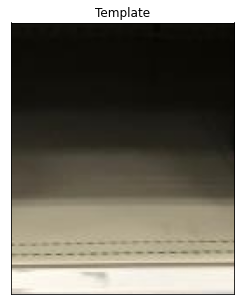

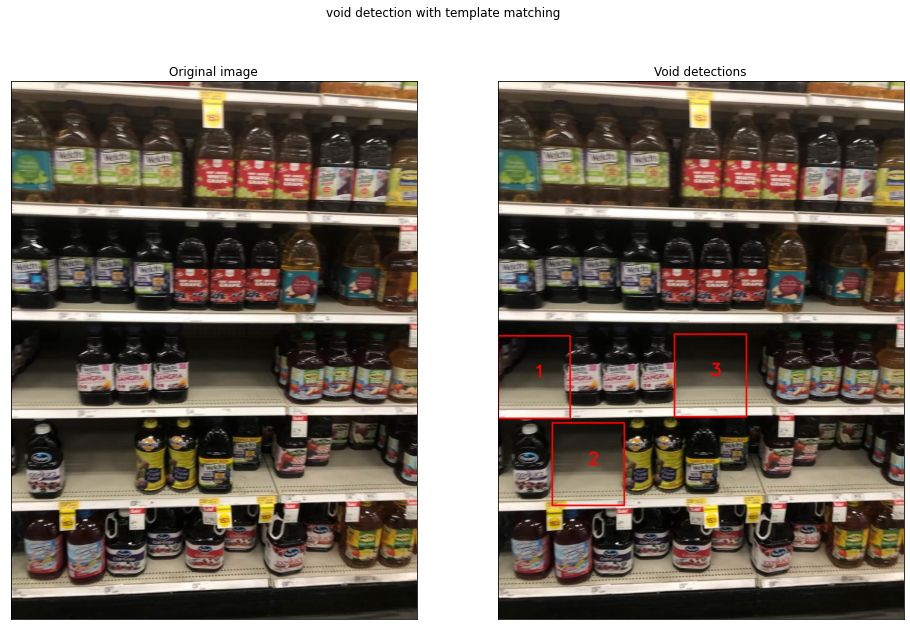

In [8]:
void_detector.show_detections() ## Check the result for debugging and evaluation